<a href="https://colab.research.google.com/github/Ziadnasser1/Machine-Learning-Training/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Builtin
Using builtin library to get the data of the `MNIST` data set.

In [25]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# BI = BuiltIn
(x_train_BI, y_train_BI), (x_test_BI, y_test_BI) = mnist.load_data()
x_train_BI, x_test_BI = x_train_BI / 255.0, x_test_BI / 255.0

x_train_BI, x_val_BI, y_train_BI, y_val_BI = train_test_split(x_train_BI, y_train_BI, test_size=0.2, random_state=42)


Convert class vectors to binary class matrices

In [27]:
y_train_BI = to_categorical(y_train_BI, 10)
y_val_BI = to_categorical(y_val_BI, 10)
y_test_BI = to_categorical(y_test_BI, 10)

In [29]:
print("Training data shape:", x_train_BI.shape)
print("Validation data shape:", x_val_BI.shape)
print("Test data shape:", x_test_BI.shape)
print("Training labels shape:", y_train_BI.shape)
print("Validation labels shape:", y_val_BI.shape)
print("Test labels shape:", y_test_BI.shape)

Training data shape: (48000, 28, 28)
Validation data shape: (12000, 28, 28)
Test data shape: (10000, 28, 28)
Training labels shape: (48000, 10)
Validation labels shape: (12000, 10)
Test labels shape: (10000, 10)


# Manually Get the data
Get the data from Files and making the functions manually.

In [19]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

This is **Load Data** function which is responsible for getting the data from the files in the content.
The files are in compressed in `gzip` format. So the function open them in `binary read` mode.
Then the function load the data in `data` variable by reading the content of the file with `.read()` and convert it to `Numpy Array`.
The `dtype=np.uint8` specifies that the data in the file should be interpreted as unsigned 8-bit integers.
While `offset=16`: Skips the first 16 bytes of the file as they usually contain the meta data.

In [32]:
def load_data(file_path, is_labels=False):
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=8 if is_labels else 16)
    if not is_labels:
        num_images = len(data) // (28 * 28)
        data = data.reshape((num_images, 28, 28))
    return data

train_images = load_data('/content/train-images-idx3-ubyte.gz')
train_labels = load_data('/content/train-labels-idx1-ubyte.gz', is_labels=True)
test_images = load_data('/content/t10k-images-idx3-ubyte.gz')
test_labels = load_data('/content/t10k-labels-idx1-ubyte.gz', is_labels=True)

In [33]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


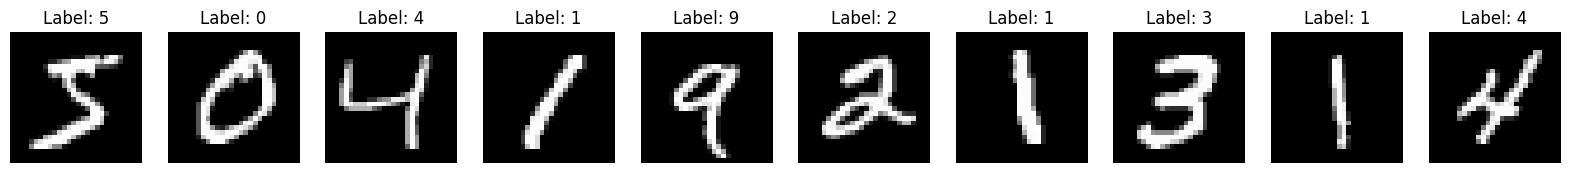

In [34]:
def plot_mnist_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.show()

train_images_reshaped = train_images.reshape(-1, 28, 28)
plot_mnist_images(train_images_reshaped, train_labels)

In [35]:
def train_validate_split(images, labels, valRatio=0.2, random_seed=None):
    total_size = len(images)
    val_size = int(total_size * valRatio)
    train_size = total_size - val_size

    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(total_size)
    train_data, train_labels = images[shuffled_indices[:train_size]], labels[shuffled_indices[:train_size]]
    val_data, val_labels = images[shuffled_indices[train_size:]], labels[shuffled_indices[train_size:]]

    return train_data, train_labels, val_data, val_labels



In [36]:
train_data, train_labels, val_data, val_labels = train_validate_split(train_images, train_labels, random_seed=42)

print(train_data.shape)
print(val_data.shape)
print(test_images.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)
